In [1]:
import string
import re

In [2]:
from nltk.stem import PorterStemmer

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
from bs4 import BeautifulSoup

In [5]:
import os
import numpy as np
import email

easy_ham_path = 'email/easy_ham/easy_ham/'
hard_ham_path = 'email/hard_ham/hard_ham/'
spam_path = 'email/spam_2/spam_2/'

In [6]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [7]:
# recuperation de l'ensemble de donnee
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

In [8]:
np.random.shuffle(ham) # melanger les ham
np.random.shuffle(spam) # melanger les spam

In [9]:
stemmer = PorterStemmer()

def nettoyage(X):
    b = email.message_from_string(X)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
                    # ignorer tout text/plain
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # recuperer le corp de l'email
                break
        # si non multipart
    else:
        body = b.get_payload(decode=True) # recuperer le corp de l'email

    soup = BeautifulSoup(body, "html.parser") #enlever les balises html
    text = soup.get_text().lower() # mettre au minuscule

    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE) #normalisation des liens

    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE) #normalisation adresses email

    text = re.sub(r'[0-9]+', 'number', text, flags=re.MULTILINE) # remplacer tout les nombres[0-9] par le mot number 
    
    text = re.sub(r'[$]+', 'dollar', text, flags=re.MULTILINE) # remplacer tout les $ par dollar
    
    text = text.translate(str.maketrans('', '', string.punctuation)) # enlever les ponctuation
    
    text = text.translate(str.maketrans('', '', '\n')) # enlever les retours de lignes

    stop_words = stopwords.words('english')
    words_list = [w for w in text.split() if w not in stop_words] # enlever les stop-words

    words_list = [stemmer.stem(w) for w in words_list] #Stemming : radicalisation des mots
    return words_list

In [10]:
# transformation des spams :
for i in range(len(spam)):
    spam[i] = nettoyage(spam[i])

# transformation des hams :
for i in range(len(ham)):
    ham[i] = nettoyage(ham[i])

c:\users\p\appdata\local\programs\python\python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
c:\users\p\appdata\local\programs\python\python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [11]:
# charger la liste de vocabulaire
vlist = np.genfromtxt('vocablist.txt', delimiter=',', dtype=str)
vlist.shape

(24259,)

# Extraction des caractéristiques :

1 - Extraction de caractéristiques de spam :

In [12]:
spam_vec = np.zeros((len(spam), len(vlist)))
for i in range(len(spam)):
    for j in range(len(spam[i])):
        # verification si le mot existe en vocablist
        if spam[i][j] in vlist:
            idx, = np.where(vlist == spam[i][j])  # recherche l'indice du mot dans vocablist 
            spam_vec[i, idx] = spam[i].count(spam[i][j]) # Màj le nombre d'occurrence du mot
            
spam_y = np.ones((len(spam),1)) # ajout de l'etiquette : classe 1 (y=1)

spam_data=np.column_stack((spam_vec,spam_y))

2 - Extraction de caractéristiques de ham :

In [13]:
ham_vec = np.zeros((len(ham), len(vlist)))
for i in range(len(ham)):
    for j in range(len(ham[i])):
        # verification si le mot existe en vocablist
        if ham[i][j] in vlist:
            idx, = np.where(vlist == ham[i][j])  # recherche l'indice du mot dans vocablist 
            ham_vec[i, idx] = ham[i].count(ham[i][j]) # Màj le nombre d'occurrence du mot
            
ham_y = np.zeros((len(ham), 1)) # ajout de l'etiquette : classe 0

ham_data=np.column_stack((ham_vec,ham_y))

Assemblage des données :

In [14]:
data = np.vstack((spam_data, ham_data))
data.shape

(4198, 24260)

In [15]:
np.random.shuffle(data) # melange des données

In [16]:
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:, :len(vlist)])) # ajout du biais
y = data[:, len(vlist)];
print(X.shape)
print(y.shape)

(4198, 24260)
(4198,)


In [17]:
# répartition de l'ensemble de données en : ensemble d'entrainement et ensemble de teste
from sklearn.model_selection import train_test_split
Xt, Xtt, yt, ytt = train_test_split(X, y, random_state=0, test_size=0.3)

# 1- Regression Logistique :

In [116]:
# focntion calcule de cout
def computeCost(X, y, theta):
    return np.sum(np.power(predict(X, theta)-y, 2))/(2*X.shape[0])

In [32]:
def Sigmoid(z):
    return 1/(1+np.exp(-z));

In [54]:
def gradientDescent(X, y, theta, alpha, iterations):
    m = len(y)
    # garder l'historique des valeurs de theta
    historique_theta = np.zeros((iterations, theta.shape[0]))
    
    for it in range(iterations):
        # calcul de la fonction hypothese
        pred = np.dot(X, theta)
        pred = Sigmoid(pred)
        # mise a jour du vecteur theta
        theta[0][0] = theta[0][0] - (1/m)*alpha*( (X[:, 0].T).dot((pred-y.reshape((m,1)))))
        theta[1:] = theta[1:] - (1/m)*alpha*( (X[:, 1:].T).dot((pred-y.reshape((m,1)))))
        
        # enregistrement de la valeur  des theta
        historique_theta[it, :] = theta.T
    
    return theta, historique_theta

In [57]:
# fonction de prediction
def predict(X, theta):
    # initilisation du seuil :
    seuil = 0.5
    # calcul des predictions
    h = np.dot(X, theta)
    y_pred = Sigmoid(h)
    
    for i in range(len(h)):
        if(y_pred[i] > seuil):
            y_pred[i] = 1  # y_pred > seuil : produit est commerciable (classe 1)
        else :
            y_pred[i] = 0  # y_pred > seuil : produit n'est pas commerciable (classe 0)
    
    
    return y_pred

In [34]:
# initialisation des theta
n=X.shape[1]
theta = np.zeros((n, 1))
theta.shape

(24260, 1)

In [ ]:
# paramètres
iterations = 3000;
alpha = 0.01;

# Appel
theta, historique_theta = gradientDescent(Xt, yt, theta, alpha, iterations);

Malheureusement, la descente de gradient prend énormement de temps pour trouver les paramètres theta optimaux. c'est pour cela qu'on s'est dirigé vers l'utilisation de librairie.

* utilisation de la librairie "Sklearn" :

In [99]:
import sklearn.linear_model

clf_rl = sklearn.linear_model.LogisticRegression()
clf_rl.fit(Xt, yt.reshape((len(yt),))) # entrainement du modele

print("precision du modele de Regression Logistique :")
print(clf_rl.score(Xtt, ytt.reshape((len(ytt),)))*100, " %")
print("\nvaleur de theta :")
print(clf_rl.coef_)
print("\nle biais :")
print(clf_rl.intercept_)

precision du modele de Regression Logistique :
97.14285714285714  %

valeur de theta :
[[0.00104866 0.00569031 0.48846367 ... 0.02551049 0.02551049 0.        ]]

le biais :
[0.81048437]


c:\users\p\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
theta = clf_rl.coef_
print("le cout est de :")
print(computeCost(Xt, yt, theta.T))

le cout est de 
657.8669162695711


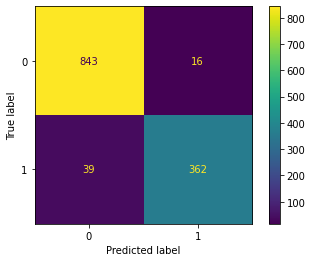

In [79]:
#matrice confusion pour la regression logistique
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ytt, clf.predict(Xtt))
ConfusionMatrixDisplay(cm).plot()

In [75]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# y_test : etiquette ensemble de test
# y_pred : etiquette de l'ensemble prédit par le modèle
def roc(y_test, y_pred):
    
    fpr = dict()
    tpr = dict()
    # la fonction roc_curve renvoi :
    # - fpr : le taux du faux positif de la classe 1
    # - tpr : le taux du vrai positif de la classe 1
    
    fpr_i, tpr_i, _ = roc_curve(y_test, y_pred)

    # dessiner la courbe de roc de la classe i avec matplotlib
    plt.plot(fpr_i, tpr_i, color='red', label='ROC')
    plt.xlabel('Taux faux positif')
    plt.ylabel('Taux vrai positif')
    plt.title('courbe ROC')
    plt.show()

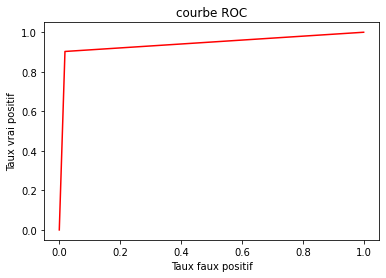

In [76]:
roc(ytt, clf.predict(Xtt)) # courbe de ROC pour la regression logistique

# 2- SVM :

In [120]:
from sklearn import svm

lin_svc = svm.SVC(C=0.1, kernel='linear').fit(Xt, yt) # entrainement du modele

y_pred_svm = lin_svc.predict(Xtt) # prediction sur l'ensemble de teste (Xtt)

print("precision du modele SVM :")
print(lin_svc.score(Xtt, ytt.reshape((len(ytt),)))*100)


precision du modele SVM :
96.82539682539682


In [123]:
theta = lin_svc.coef_
print("le cout est de :")
print(computeCost(Xt, yt, theta.T))

le cout est de :
650.139210347175


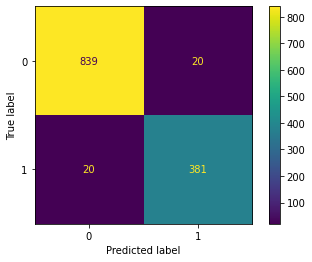

In [88]:
# matrice de confusion pour le modele SVM

cm_svm = confusion_matrix(ytt, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot()

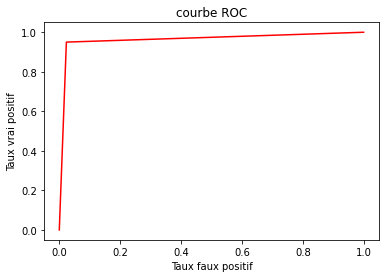

In [89]:
roc(ytt, y_pred_svm, 1) # courbe de ROC pour le modele SVM

# 3- Réseau de Neurone :

In [90]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(Xt, yt) # entrainement du modele

y_pred = clf.predict(Xtt) # prediction sur l'ensemble de teste (Xtt)

precision = np.mean(ytt==y_pred)*100
print("\nvaleur de la precision du modele RN :")
print(precision)


valeur de la precision du modele RN :
95.95238095238095


In [122]:
theta = clf.coef_
print("le cout du modele de RN est de :")
print(computeCost(Xt, yt, theta.T))

le cout du modele de RN est de :
657.8669162695711


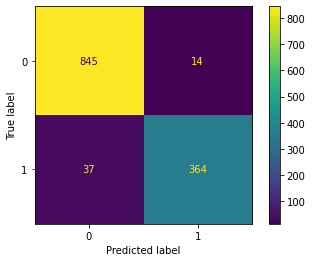

In [92]:
# matrice de confusion pour le modele de RN
cm_rn = confusion_matrix(ytt, y_pred)
ConfusionMatrixDisplay(cm_rn).plot()

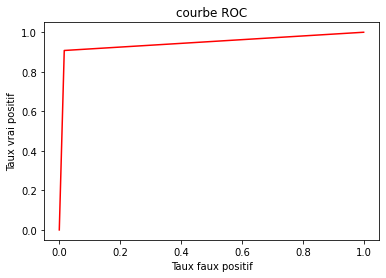

In [93]:
roc(ytt, y_pred, 1) # courbe de ROC pour le modele RN

In [18]:
import tensorflow as tf
from tensorflow import keras

#modeling
model = keras.Sequential()
model.add(keras.layers.Embedding(4096, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


AttributeError: module 'tensorflow._api.v2.train' has no attribute 'AdamOptimizer'

In [19]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(Xt[500:],
                    yt[500:],
                    epochs=300,
                    batch_size=100,
                    validation_data=(Xt[:500], yt[:500]),
                    verbose=1, callbacks=[early_stop])

Epoch 1/300
25/25 [==============================] - 9s 298ms/step - loss: 0.6869 - accuracy: 0.6537 - val_loss: 0.6715 - val_accuracy: 0.6560
Epoch 2/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6636 - accuracy: 0.6676 - val_loss: 0.6506 - val_accuracy: 0.6560
Epoch 3/300
25/25 [==============================] - 7s 282ms/step - loss: 0.6454 - accuracy: 0.6609 - val_loss: 0.6436 - val_accuracy: 0.6560
Epoch 4/300
25/25 [==============================] - 7s 280ms/step - loss: 0.6359 - accuracy: 0.6681 - val_loss: 0.6440 - val_accuracy: 0.6560
Epoch 5/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6349 - accuracy: 0.6690 - val_loss: 0.6437 - val_accuracy: 0.6560
Epoch 6/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6366 - accuracy: 0.6665 - val_loss: 0.6436 - val_accuracy: 0.6560
Epoch 7/300
25/25 [==============================] - 7s 282ms/step - loss: 0.6411 - accuracy: 0.6598 - val_loss: 0.6436 - val_accuracy: 0.6560

Epoch 58/300
25/25 [==============================] - 7s 292ms/step - loss: 0.6321 - accuracy: 0.6710 - val_loss: 0.6413 - val_accuracy: 0.6560
Epoch 59/300
25/25 [==============================] - 7s 287ms/step - loss: 0.6391 - accuracy: 0.6598 - val_loss: 0.6411 - val_accuracy: 0.6560
Epoch 60/300
25/25 [==============================] - 7s 282ms/step - loss: 0.6353 - accuracy: 0.6665 - val_loss: 0.6411 - val_accuracy: 0.6560
Epoch 61/300
25/25 [==============================] - 7s 289ms/step - loss: 0.6337 - accuracy: 0.6677 - val_loss: 0.6413 - val_accuracy: 0.6560
Epoch 62/300
25/25 [==============================] - 7s 291ms/step - loss: 0.6410 - accuracy: 0.6566 - val_loss: 0.6411 - val_accuracy: 0.6560
Epoch 63/300
25/25 [==============================] - 7s 297ms/step - loss: 0.6380 - accuracy: 0.6613 - val_loss: 0.6408 - val_accuracy: 0.6560
Epoch 64/300
25/25 [==============================] - 7s 288ms/step - loss: 0.6271 - accuracy: 0.6772 - val_loss: 0.6407 - val_accuracy:

Epoch 115/300
25/25 [==============================] - 7s 279ms/step - loss: 0.6137 - accuracy: 0.6755 - val_loss: 0.6315 - val_accuracy: 0.6560
Epoch 116/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6220 - accuracy: 0.6701 - val_loss: 0.6309 - val_accuracy: 0.6560
Epoch 117/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6241 - accuracy: 0.6645 - val_loss: 0.6304 - val_accuracy: 0.6560
Epoch 118/300
25/25 [==============================] - 7s 283ms/step - loss: 0.6177 - accuracy: 0.6767 - val_loss: 0.6299 - val_accuracy: 0.6560
Epoch 119/300
25/25 [==============================] - 7s 277ms/step - loss: 0.6245 - accuracy: 0.6644 - val_loss: 0.6303 - val_accuracy: 0.6560
Epoch 120/300
25/25 [==============================] - 7s 281ms/step - loss: 0.6157 - accuracy: 0.6743 - val_loss: 0.6286 - val_accuracy: 0.6560
Epoch 121/300
25/25 [==============================] - 7s 282ms/step - loss: 0.6182 - accuracy: 0.6677 - val_loss: 0.6283 - val_ac

25/25 [==============================] - 7s 288ms/step - loss: 0.6153 - accuracy: 0.6571 - val_loss: 0.6262 - val_accuracy: 0.6560
Epoch 172/300
25/25 [==============================] - 7s 287ms/step - loss: 0.6080 - accuracy: 0.6670 - val_loss: 0.6210 - val_accuracy: 0.6560
Epoch 173/300
25/25 [==============================] - 7s 282ms/step - loss: 0.6084 - accuracy: 0.6626 - val_loss: 0.6213 - val_accuracy: 0.6560
Epoch 174/300
25/25 [==============================] - 7s 283ms/step - loss: 0.6167 - accuracy: 0.6568 - val_loss: 0.6217 - val_accuracy: 0.6560
Epoch 175/300
25/25 [==============================] - 7s 285ms/step - loss: 0.6055 - accuracy: 0.6669 - val_loss: 0.6222 - val_accuracy: 0.6560
Epoch 176/300
25/25 [==============================] - 7s 284ms/step - loss: 0.6146 - accuracy: 0.6652 - val_loss: 0.6216 - val_accuracy: 0.6560
Epoch 177/300
25/25 [==============================] - 7s 285ms/step - loss: 0.6163 - accuracy: 0.6594 - val_loss: 0.6226 - val_accuracy: 0.6560

In [21]:
results = model.evaluate(Xtt, ytt)
print("Final Test Set Results: {}".format(results))

40/40 [==============================] - 1s 22ms/step - loss: 0.6051 - accuracy: 0.6762
Final Test Set Results: [0.605147123336792, 0.6761904954910278]


In [22]:
Xt_N = Xt.astype('float32')
Xtt_N = Xtt.astype('float32')

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(24260, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='sigmoid'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# entrainer le modèle
model.fit(Xt_N, yt)

# evaluaer le modèle
_, acc = model.evaluate(Xtt_N, ytt, verbose=0)
y_pred4 = np.argmax(model.predict(Xtt_N),axis = 1)


ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 24260, 1)

In [ ]:
rounded_labels = np.argmax(ytt, axis=1)
mc4 = matrice_confusion(rounded_labels, y_pred4)
print("la matrice de confusion du RNC :")
print(mc4)


tf4 = taux_FP(mc4)
spec4 = specificite(mc4)

roc(rounded_labels, y_pred4)